In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
sns.set(rc={'figure.figsize':(10,6)})

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import joblib

In [2]:
TRAIN_PATH = Path('data/mitbih_train.csv')
TEST_PATH = Path('data/mitbih_test.csv')
os.listdir(path='data')

['mitbih_test.csv', 'mitbih_train.csv']

In [3]:
train_set = pd.read_csv(TRAIN_PATH, header=None)
test_set = pd.read_csv(TEST_PATH, header=None)

In [4]:
# convert float64's to float32's to save space
for col in train_set.columns:
    if train_set[col].dtype == 'float64':
        train_set[col]=pd.to_numeric(train_set[col], downcast='float')

for col in test_set.columns:
    if test_set[col].dtype == 'float64':
        test_set[col]=pd.to_numeric(test_set[col], downcast='float')

assert (train_set.dtypes == 'float32').all()
assert (test_set.dtypes == 'float32').all()

In [5]:
# check for columns with at least one null value
assert len(train_set.columns[train_set.isnull().any()]) == 0

In [6]:
# data already scaled between 0-1
# scaler = MinMaxScaler(feature_range=(0, 1))
print(f'Training Data Shape: {train_set.shape}')
print(f'Test Data Shape: {test_set.shape}')

Training Data Shape: (87554, 188)
Test Data Shape: (21892, 188)


In [7]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# class balance
train_set.iloc[:, 187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [9]:
test_set.iloc[:, 187].value_counts()

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64

In [10]:
# Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
# 0=normal (N), 1=SVEB (S), 2=VEB (V), 3=Fusion beat (F), 4=Unknown beat (Q)

"""
• N: Normal beat
• S: Supraventricular premature beat
• V: Premature ventricular contraction
• F: Fusion of ventricular and normal beat
• Q: Unclassifiable beat

N
Normal
Left/Right bundle branch block
Atrial escape
Nodal escape

S
Atrial premature
Aberrant atrial premature
Nodal premature
Supra-ventricular premature

V
Premature ventricular contraction
Ventricular escape

F
Fusion of ventricular and normal

Q
Paced
Fusion of paced and normal
Unclassifiable
""";

<AxesSubplot: >

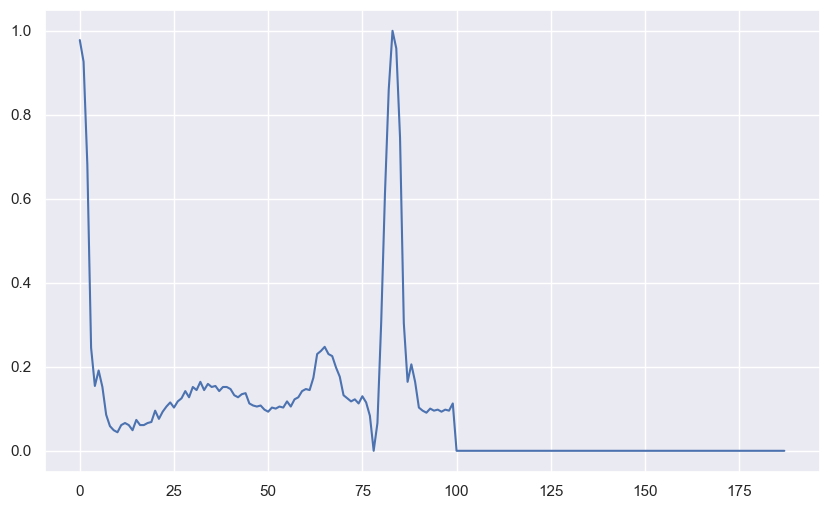

In [11]:
# each row represents one cardiac cycle (heartbeat)
train_set.iloc[0].plot()

In [12]:
# randomly sample training data and plot
def subplot_random_rows(data, num_samples=0):
    data = data.iloc[:, :-1]
    shuffled_indices = np.random.permutation(len(data))
    indices_to_plot = shuffled_indices[:num_samples]
    random_data = data.iloc[indices_to_plot]
    
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.plot(np.arange(0,187), random_data.iloc[i,:])
    
    return plt.show()

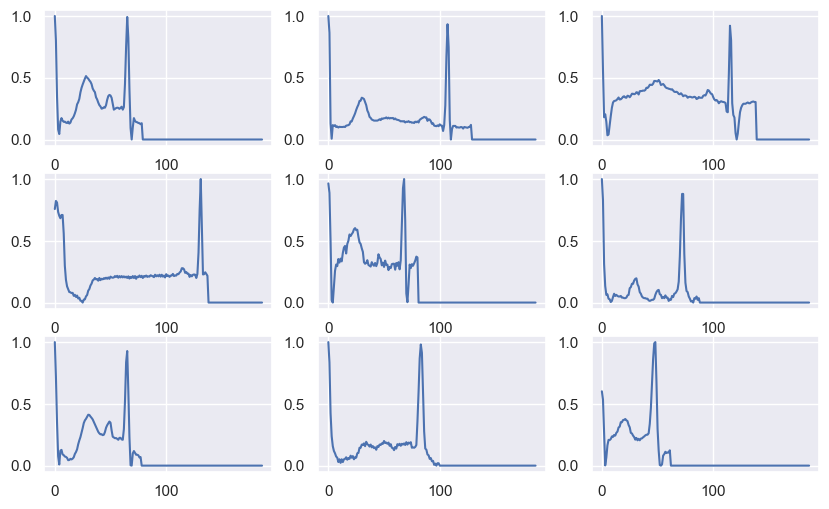

In [13]:
subplot_random_rows(train_set, num_samples=9)

In [14]:
def balance_classes(data, class_size=0):
    labels_0 = data[data[187]==0].sample(n=class_size,random_state=42)
    labels_1 = data[data[187]==1]
    labels_2 = data[data[187]==2]
    labels_3 = data[data[187]==3]
    labels_4 = data[data[187]==4]
    
    labels_1_up = resample(labels_1, replace=True, n_samples=class_size, random_state=33)
    labels_2_up = resample(labels_2, replace=True, n_samples=class_size, random_state=34)
    labels_3_up = resample(labels_3, replace=True, n_samples=class_size, random_state=35)
    labels_4_up = resample(labels_4, replace=True, n_samples=class_size, random_state=36)
    
    final_df = pd.concat([labels_0, labels_1_up, labels_2_up, labels_3_up, labels_4_up])
    final_df.reset_index(drop=True, inplace=True)
    return final_df

In [15]:
def train_model(train_set):
    # split data into features and labels
    X_train = train_set.iloc[:, :-1]
    y_train = train_set.iloc[:, -1]
    # relu activation is default
    mlp = MLPClassifier(hidden_layer_sizes=(75, 75, 75), max_iter=300)
    mlp.fit(X_train, y_train)
    print(f'Model created from {len(X_train)} records')
    return mlp

In [16]:
def split_validation_data(test_set):
    X_test, X_val, y_test, y_val = train_test_split(test_set.iloc[:, :-1], 
                                                    test_set.iloc[:, -1], 
                                                    test_size=0.3,
                                                    random_state=42)
    return (X_test, X_val, y_test, y_val)

In [17]:
def evaluate_model(mlp, X_test, y_test):
    y_pred = mlp.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("=" * 100)
    cm = confusion_matrix(y_test, y_pred, labels=mlp.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
    disp.plot(cmap='Blues')

In [18]:
def validate_model(train_set):
    X_train = train_set.iloc[:, :-1]
    y_train = train_set.iloc[:, -1]

    kf = KFold(n_splits=10)
    mlp = MLPClassifier(hidden_layer_sizes=(75, 75, 75), max_iter=300)

    for train_indices, test_indices in kf.split(X_train):
        mlp.fit(X_train[train_indices], y_train[train_indices])
        print(mlp.score(X_train[test_indices], y_train[test_indices]))

In [19]:
def tune_hypers(train_set):
    X_train = train_set.iloc[:, :-1]
    y_train = train_set.iloc[:, -1]

    param_grid = { 
        'max_iter' : [300, 600, 1000],
        'hidden_layer_sizes': [75, 100, 125]
    }
    gs = GridSearchCV(MLPClassifier(), param_grid, cv=5)
    gs.fit(X_train, y_train)
    gs._best_estimator 

#### Create model with unbalanced classes

In [20]:
# model = train_model(train_set)
# val_data = split_validation_data(test_set)
# evaluate_model(model, val_data[0], val_data[2])

#### Create model with balanced classes

Model created from 90000 records
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87      3102
         1.0       0.95      0.83      0.88      3025
         2.0       0.89      0.94      0.92      3089
         3.0       0.96      0.85      0.90      3071
         4.0       0.98      0.98      0.98      3113

    accuracy                           0.91     15400
   macro avg       0.92      0.91      0.91     15400
weighted avg       0.92      0.91      0.91     15400



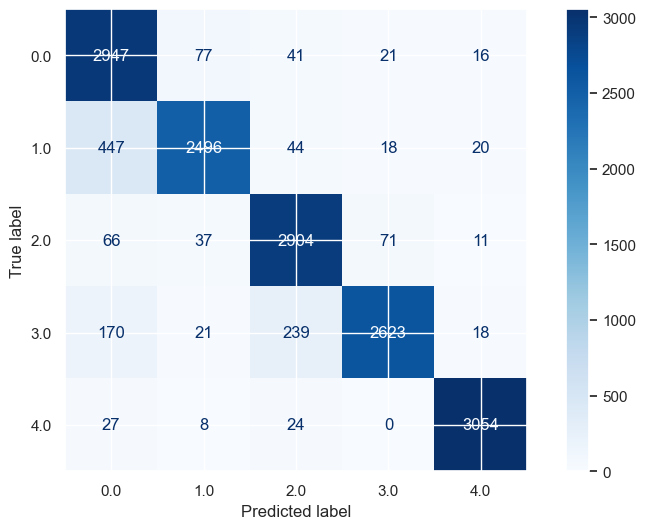

In [79]:
train_set_balanced = balance_classes(train_set, class_size=18000)
test_set_balanced = balance_classes(test_set, class_size=4400)

balanced_model = train_model(train_set_balanced)
val_data = split_validation_data(test_set_balanced)
evaluate_model(balanced_model, val_data[0], val_data[2])

In [367]:
joblib.dump(model, "EKG_nn.pkl")

['EKG_nn.pkl']